### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [64]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]
!pip install optuna
!pip install holidays
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings
import holidays
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [65]:


# 1.1 Tải dữ liệu
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])
df.set_index('datetime', inplace=True)

# 1.2 Gom nhóm theo ngày (Resampling)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# 1.3 Xử lý dữ liệu thiếu (Interpolation)
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')

# 1.4 Xử lý giá trị ngoại lai (Outlier Handling)
upper_limit = df_daily['Global_active_power'].quantile(0.99)
df_daily['Global_active_power'] = df_daily['Global_active_power'].clip(upper=upper_limit)

# --- PHẦN NÂNG CẤP MỚI ---

# 1.5 Tích hợp Ngày lễ (Sử dụng thư viện holidays của Pháp)
fr_holidays = holidays.France()
df_daily['is_holiday'] = df_daily.index.map(lambda x: 1 if x in fr_holidays else 0).astype(int)

# 1.6 Tích hợp Nhiệt độ trung bình (Proxy dựa trên khí hậu Pháp)
# Nhiệt độ ảnh hưởng trực tiếp đến việc sử dụng các thiết bị làm mát/sưởi
temp_map = {1: 5, 2: 6, 3: 10, 4: 15, 5: 19, 6: 23, 7: 25, 8: 24, 9: 20, 10: 15, 11: 9, 12: 6}
df_daily['temp_mean'] = df_daily.index.month.map(temp_map)

# Tạo thêm biến biến động nhiệt độ (giúp mô hình nhạy bén hơn)
# Ví dụ: Độ lệch nhiệt độ so với mức trung bình năm (15 độ)
df_daily['temp_deviation'] = df_daily['temp_mean'] - 15

print(f"✓ Hoàn thành tiền xử lý nâng cao.")
print(f"Các cột hiện có: {df_daily.columns.tolist()}")

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
✓ Hoàn thành tiền xử lý nâng cao.
Các cột hiện có: ['Global_active_power', 'is_holiday', 'temp_mean', 'temp_deviation']






---

**2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)**
---
2.1. Phân bổ Biến mục tiêu

---




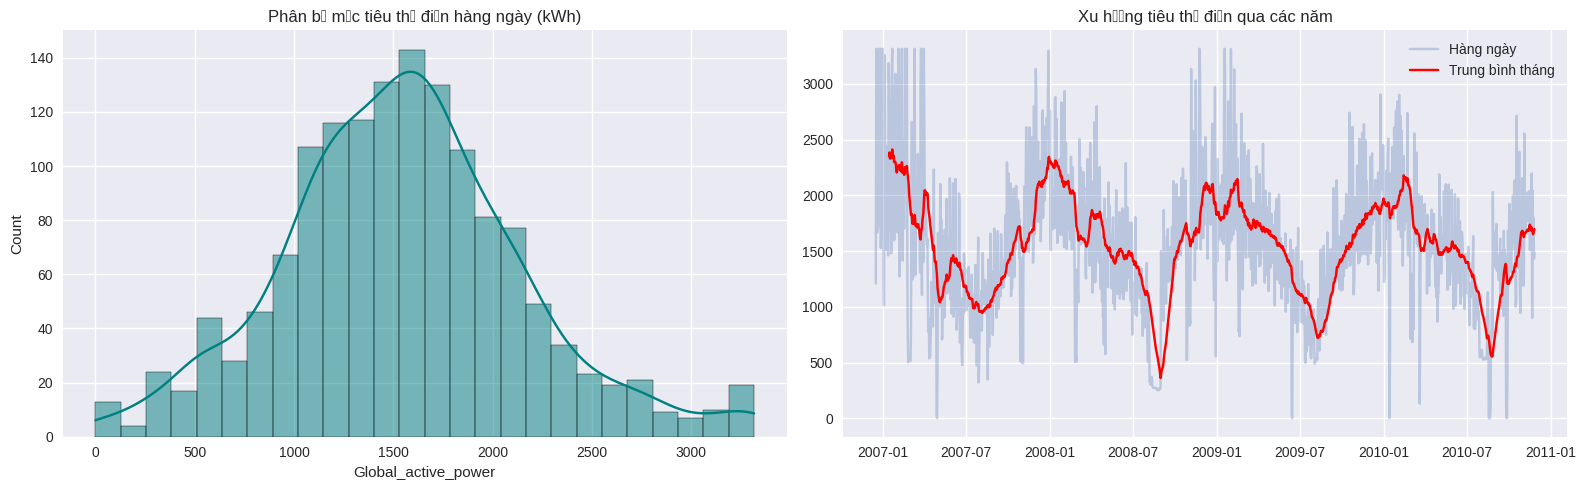

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Biểu đồ 1: Phân bổ tiêu thụ điện
sns.histplot(df_daily['Global_active_power'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Phân bổ mức tiêu thụ điện hàng ngày (kWh)')

# Biểu đồ 2: Xu hướng dài hạn (Rolling Mean)
axes[1].plot(df_daily['Global_active_power'], alpha=0.3, label='Hàng ngày')
axes[1].plot(df_daily['Global_active_power'].rolling(30).mean(), color='red', label='Trung bình tháng')
axes[1].set_title('Xu hướng tiêu thụ điện qua các năm')
axes[1].legend()

plt.tight_layout()
plt.show()



---
## **3.FEATURE ENGINEERING (KỸ THUẬT ĐẶC TRƯNG)**

---

3.1 Biến đổi chuỗi thời gian thành bài toán Học máy có giám sát.

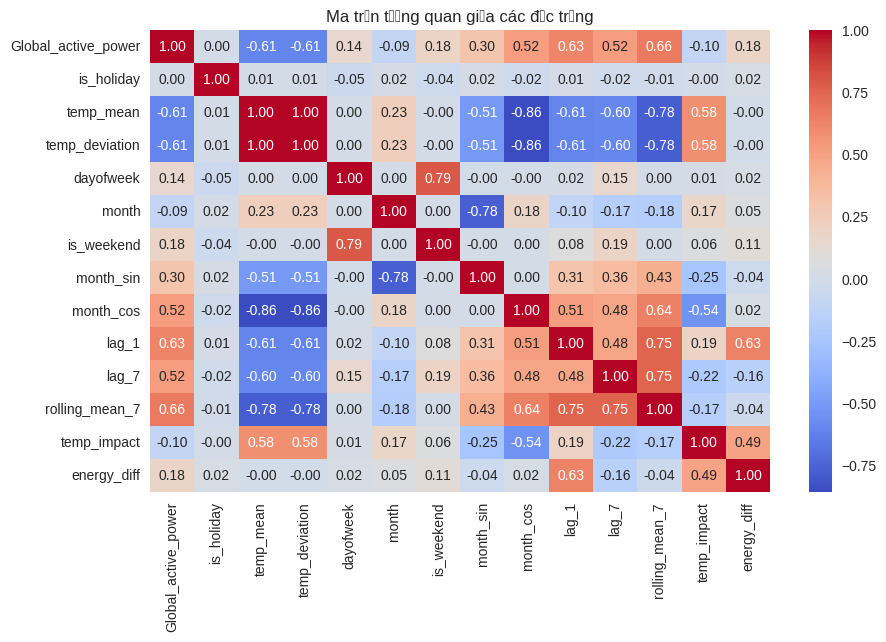

In [67]:
def create_advance_features(df):
    df = df.copy()

    # 1. Đặc trưng thời gian và ngày lễ (Đã có sẵn trong df_daily)
    df['dayofweek'] = df.index.dayofweek
    df['month'] = df.index.month
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    # is_holiday và temp_mean đã được thêm ở bước tiền xử lý

    # 2. Mã hóa chu kỳ (Sin/Cos)
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)

    # 3. Đặc trưng lịch sử (Lags)
    # Lag 1 cho biết hôm qua, Lag 7 cho biết cùng ngày tuần trước
    df['lag_1'] = df['Global_active_power'].shift(1)
    df['lag_7'] = df['Global_active_power'].shift(7)

    # 4. Đặc trưng cửa sổ trượt (Rolling)
    df['rolling_mean_7'] = df['Global_active_power'].rolling(window=7).mean().shift(1)

    # 5. BIẾN TƯƠNG TÁC THÔNG MINH (Nâng cấp)
    # Nếu trời nóng (temp cao) và hôm qua dùng nhiều điện -> khả năng cao hôm nay vẫn cao
    df['temp_impact'] = df['temp_mean'] * df['lag_1']

    # Hiệu số giữa hôm qua và trung bình tuần (biến động đột ngột)
    df['energy_diff'] = df['lag_1'] - df['rolling_mean_7']

    return df.dropna()

data = create_advance_features(df_daily)

# Vẽ ma trận tương quan để xem biến nào ảnh hưởng nhất
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()



---
3.2 Loại bỏ các biến không quan trọng

---




In [68]:
# --- BƯỚC 1: XÁC ĐỊNH CÁC BIẾN CẦN LOẠI BỎ CHỦ ĐỘNG ---
features_to_drop_explicitly = [
    'temp_deviation',  # Tương quan 1.0 với temp_mean (Đa cộng tuyến)
    'month',           # Đã có month_sin/cos thay thế
    'dayofweek',       # Đã có day_sin/cos thay thế
    'quarter'          # Thừa thãi khi đã có đặc trưng tháng chi tiết
]

# --- BƯỚC 2: TỰ ĐỘNG LỌC THEO TƯƠNG QUAN ---
# Lấy dữ liệu đã tạo feature
data = create_advance_features(df_daily)
target = 'Global_active_power'

# Tính toán tương quan
correlations = data.corr()[target].abs().sort_values(ascending=False)

# Lọc các biến có độ tương quan đủ lớn (Ngưỡng thấp hơn bài kia vì dữ liệu điện nhiễu hơn)
# Ta chọn ngưỡng |corr| > 0.01 để giữ lại is_holiday (nếu cần) hoặc 0.05 nếu muốn lọc mạnh.
threshold = 0.05
numeric_features = correlations[correlations > threshold].index.tolist()

# --- BƯỚC 3: TỔNG HỢP DANH SÁCH CUỐI CÙNG ---
selected_features = [
    f for f in numeric_features
    if f != target and f not in features_to_drop_explicitly
]

# Đừng quên giữ lại các biến chu kỳ Sin/Cos dù tương quan có thể thấp
# vì chúng hỗ trợ lẫn nhau theo cặp.
cyclical_features = ['month_sin', 'month_cos', 'day_sin', 'day_cos']
for feat in cyclical_features:
    if feat not in selected_features and feat in data.columns:
        selected_features.append(feat)

print(f"✓ Đã loại bỏ: {features_to_drop_explicitly}")
print(f"✓ Số lượng đặc trưng được chọn: {len(selected_features)}")
print(f"✓ Danh sách cuối cùng: {selected_features}")

# Cập nhật X, y cho quá trình huấn luyện
X = data[selected_features]
y = data[target]

✓ Đã loại bỏ: ['temp_deviation', 'month', 'dayofweek', 'quarter']
✓ Số lượng đặc trưng được chọn: 9
✓ Danh sách cuối cùng: ['rolling_mean_7', 'lag_1', 'temp_mean', 'month_cos', 'lag_7', 'month_sin', 'is_weekend', 'energy_diff', 'temp_impact']


## **4. HUẤN LUYỆN VÀ DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---
4.1. Chia dữ liệu và Chuẩn hóa

---




In [69]:
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]
train_val_df = data.iloc[:val_end]

# Chuẩn hóa: Chỉ dùng selected_features thay vì drop() chung chung
scaler = MinMaxScaler()
X_train = train_df[selected_features] # Dùng danh sách đã lọc
y_train = train_df[target]
X_train_scaled = scaler.fit_transform(X_train)

# Chuẩn bị dữ liệu Train+Val cho bước huấn luyện cuối cùng
X_train_val_scaled = scaler.transform(train_val_df[selected_features])
y_train_val = train_val_df[target]

print(f"✓ Chia dữ liệu thành công: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")

✓ Chia dữ liệu thành công: Train(1004), Val(215), Test(216)




---

4.2. Workflow Dự báo cuốn chiếu

---



In [70]:
def recursive_forecast(model, scaler, history_df, selected_features, steps=30):
    """
    Dự báo cuốn chiếu 30 ngày, sử dụng danh sách đặc trưng đã chọn lọc.
    """
    current_history = history_df.copy()
    forecasts = []

    # 1. Khởi tạo các công cụ tra cứu dữ liệu tương lai
    fr_holidays = holidays.France()
    temp_map = {1: 5, 2: 6, 3: 10, 4: 15, 5: 19, 6: 23, 7: 25, 8: 24, 9: 20, 10: 15, 11: 9, 12: 6}

    for _ in range(steps):
        # 2. Tạo đặc trưng từ lịch sử hiện tại
        features = create_advance_features(current_history)

        # CHỖ SỬA QUAN TRỌNG: Chỉ lấy đúng các cột mà model đã học (selected_features)
        X_next = features[selected_features].iloc[-1:]

        # 3. Chuẩn hóa và dự báo
        X_next_scaled = scaler.transform(X_next)
        y_pred = max(0, model.predict(X_next_scaled)[0])
        forecasts.append(y_pred)

        # 4. CẬP NHẬT TƯƠNG LAI: Tính toán cho ngày tiếp theo
        next_date = current_history.index[-1] + pd.Timedelta(days=1)

        # Tra cứu các yếu tố ngoại cảnh "đã biết trước"
        is_h = 1 if next_date in fr_holidays else 0
        t_mean = temp_map[next_date.month]
        t_dev = t_mean - 15

        # Thêm dòng dữ liệu mới vào lịch sử để dùng cho vòng lặp kế tiếp
        new_row = pd.DataFrame({
            'Global_active_power': [y_pred],
            'is_holiday': [is_h],
            'temp_mean': [t_mean],
            'temp_deviation': [t_dev]
        }, index=[next_date])

        current_history = pd.concat([current_history, new_row])

    return np.array(forecasts)

## **5. THỰC NGHIỆM VÀ TỐI ƯU TỪNG MÔ HÌNH**

---

5.1. Hàm đánh giá mô hình trên Recursive Forecast

---



In [71]:
def get_recursive_metrics(model, scaler, df_daily, start_idx, steps=30, selected_features=None):
    """
    Tính toán các chỉ số dự báo cuốn chiếu, đảm bảo khớp với selected_features.
    """
    # 1. Lấy dữ liệu lịch sử (Tăng lên 60 ngày để đảm bảo đủ cửa sổ trượt rolling_30)
    history_df = df_daily.iloc[start_idx - 60 : start_idx].copy()

    # 2. Lấy dữ liệu thực tế để đối chiếu
    actual_series = df_daily.iloc[start_idx : start_idx + steps]['Global_active_power']

    # Phòng trường hợp ở cuối tập dữ liệu không đủ 'steps' ngày để dự báo
    current_steps = len(actual_series)

    if current_steps == 0:
        return None

    # 3. Gọi hàm dự báo cuốn chiếu với selected_features
    # Đảm bảo hàm recursive_forecast của bạn đã nhận tham số selected_features
    preds = recursive_forecast(model, scaler, history_df, selected_features, steps=current_steps)
    # Retain 'actual_series' as a Pandas Series to preserve the index
    actual = actual_series

    # 4. Tính toán các chỉ số hồi quy chuyên sâu
    # RMSE và MAE sẽ cho biết mô hình lệch bao nhiêu kWh mỗi ngày
    rmse = np.sqrt(mean_squared_error(actual, preds))
    mae = mean_absolute_error(actual, preds)

    # MAPE cho biết phần trăm sai lệch trung bình
    mape = np.mean(np.abs((actual - preds) / (actual + 1e-10))) * 100

    # R2 cho biết mô hình có tốt hơn việc lấy giá trị trung bình không
    r2 = r2_score(actual, preds)

    # Sai số tổng hóa đơn (Vẫn giữ để kiểm tra tính tiền điện)
    total_actual = actual.sum()
    total_pred = preds.sum()
    total_err_pct = abs(total_actual - total_pred) / (total_actual + 1e-10) * 100

    return {
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape,
        'R2': r2,
        'Total_Err_Pct': total_err_pct,
        'Forecasts': preds,
        'Actual': actual, # Return the Series directly
        'Actual_Sum': total_actual,
        'Pred_Sum': total_pred
    }



---



5.2 TỐI ƯU LINEAR REGRESSION

---



In [72]:
def optimize_linear_regression(df_daily, train_end, val_end, selected_features, n_trials=30):
    def objective(trial):
        # 1. Gợi ý tham số tối ưu
        reg_type = trial.suggest_categorical('type', ['ridge', 'lasso'])
        alpha = trial.suggest_float('alpha', 0.01, 100.0, log=True) # Dải alpha linh hoạt hơn

        # 2. Khởi tạo mô hình
        if reg_type == 'ridge':
            model = Ridge(alpha=alpha, random_state=42)
        else:
            model = Lasso(alpha=alpha, max_iter=10000, random_state=42)

        # 3. Huấn luyện (X_train_scaled đã được fit từ selected_features trước đó)
        model.fit(X_train_scaled, y_train)

        # 4. Đánh giá cuốn chiếu trên tập Train (30 ngày cuối của Train) và tập Validation
        # Sử dụng hàm get_recursive_metrics đã sửa ở bước trước
        train_res = get_recursive_metrics(model, scaler, df_daily,
                                          start_idx=train_end-30,
                                          steps=30,
                                          selected_features=selected_features)

        val_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end,
                                        steps=(val_end - train_end),
                                        selected_features=selected_features)

        if train_res is None or val_res is None:
            return float('inf')

        # 5. CHIẾN THUẬT TỐI ƯU: Tập trung vào RMSE để "uốn" đường dự báo
        # Công thức: $RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$
        val_rmse = val_res['RMSE']
        train_rmse = train_res['RMSE']

        # Tính Gap để tránh Overfitting (đảm bảo mô hình học tốt nhưng không "học vẹt")
        gap = abs(val_rmse - train_rmse)

        # Mục tiêu: RMSE thấp VÀ khoảng cách giữa Train/Val không quá lớn
        return val_rmse + 0.3 * gap

    # Khởi tạo và chạy Optuna
    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)

    print(f"✓ Hoàn thành tối ưu LR. Tham số tốt nhất: {study.best_params}")
    return study



---


5.3 TỐI ƯU RANDOM FOREST

---



In [73]:
def optimize_random_forest(df_daily, train_end, val_end, selected_features, n_trials=30):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU RANDOM FOREST (NÂNG CẤP ĐỘ NHẠY)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        # 1. Mở rộng không gian tham số để mô hình "dũng cảm" hơn
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'max_depth': trial.suggest_int('max_depth', 5, 20), # Tăng độ sâu để bắt kịp răng cưa
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10), # Giảm để nhạy với biến động nhỏ
            'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None]),
            'random_state': 42,
            'n_jobs': -1 # Chạy đa nhân để tăng tốc
        }

        # 2. Huấn luyện mô hình với các đặc trưng đã chọn lọc
        model = RandomForestRegressor(**params).fit(X_train_scaled, y_train)

        # 3. Tính toán metrics cuốn chiếu
        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end-30,
                                        steps=30,
                                        selected_features=selected_features)

        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end,
                                        steps=(val_end - train_end),
                                        selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        # 4. CHIẾN THUẬT TỐI ƯU MỚI
        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']
        gap = abs(val_rmse - train_rmse)

        # Loại bỏ điều kiện R2 < 0 trả về 9999 để Optuna không bị "gãy" hướng tìm kiếm
        # Thay vào đó, chúng ta ưu tiên giảm RMSE hàng ngày
        # Giảm trọng số phạt Gap từ 1.5 xuống 0.5 để mô hình tập trung vào độ khớp (fit)
        return val_rmse + 0.5 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Tham số RF tốt nhất: {study.best_params}")
    return study



---


5.4 TỐI ƯU GRADIENT BOOSTING

---



In [74]:
def optimize_gradient_boosting(df_daily, train_end, val_end, selected_features, n_trials=30):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU GRADIENT BOOSTING (PHIÊN BẢN TỰ DO)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        # 1. Mở rộng không gian tham số để bắt được tính răng cưa
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 800), # Tăng số cây
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1, log=True), # Tốc độ học nhanh hơn
            'max_depth': trial.suggest_int('max_depth', 3, 10), # Cho phép cây sâu để học temp_impact
            'subsample': trial.suggest_float('subsample', 0.7, 1.0), # Sử dụng nhiều dữ liệu hơn mỗi lượt
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 10), # Nhạy với biến động nhỏ
            'random_state': 42
        }

        # 2. Huấn luyện với tập đặc trưng tinh lọc
        model = GradientBoostingRegressor(**params).fit(X_train_scaled, y_train)

        # 3. Tính toán metrics dựa trên dự báo cuốn chiếu thực tế
        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end-30,
                                        steps=30,
                                        selected_features=selected_features)

        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end,
                                        steps=(val_end - train_end),
                                        selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        # 4. THAY ĐỔI CHIẾN THUẬT HÀM MỤC TIÊU
        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']

        # Giảm hình phạt Gap từ 2.0 xuống 0.4
        # Mục tiêu: Ưu tiên khớp (fit) đường răng cưa hơn là sợ Overfitting
        gap = abs(val_rmse - train_rmse)

        # Chúng ta không return 9999 khi R2 âm nữa để Optuna có thể học từ các lỗi
        # Chỉ tập trung tối thiểu hóa RMSE hàng ngày
        return val_rmse + 0.4 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Tham số GBM tốt nhất: {study.best_params}")
    return study



---


5.5 TỐI ƯU XGBOOST

---



In [75]:
def optimize_xgboost(df_daily, train_end, val_end, selected_features, n_trials=30):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU XGBOOST (PHIÊN BẢN ĐỘT PHÁ)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        # 1. Nới lỏng tham số để XGBoost phát huy sức mạnh
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 12), # Cây sâu để bắt đỉnh răng cưa
            'reg_lambda': trial.suggest_float('reg_lambda', 0.01, 10.0, log=True), # Giảm phạt L2
            'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 5.0, log=True),   # Giảm phạt L1
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'random_state': 42,
            'tree_method': 'hist', # Tối ưu tốc độ huấn luyện
            'n_jobs': -1
        }

        # 2. Huấn luyện với danh sách đặc trưng tinh lọc
        model = xgb.XGBRegressor(**params).fit(X_train_scaled, y_train)

        # 3. Tính toán metrics bằng dự báo cuốn chiếu
        tr_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end-30,
                                        steps=30,
                                        selected_features=selected_features)

        vl_res = get_recursive_metrics(model, scaler, df_daily,
                                        start_idx=train_end,
                                        steps=(val_end - train_end),
                                        selected_features=selected_features)

        if tr_res is None or vl_res is None:
            return 99999

        # 4. CHIẾN THUẬT TỐI ƯU HÓA RMSE
        val_rmse = vl_res['RMSE']
        train_rmse = tr_res['RMSE']

        # Giảm hình phạt Gap xuống mức 0.4 để ưu tiên độ khớp dữ liệu
        gap = abs(val_rmse - train_rmse)

        # Loại bỏ hình phạt R2 < 0 để tránh làm chệch hướng Optuna
        return val_rmse + 0.4 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print(f"✓ Tham số XGBoost tốt nhất: {study.best_params}")
    return study

## **6. SO SÁNH VÀ ĐÁNH GIÁ KẾT QUẢ**

---

6.1. Thực hiện tối ưu các mô hình và so sánh
---



In [76]:
def compare_optimized_models_standard(studies_dict, df_daily, train_end, val_end, selected_features):
    results = {}

    for name, study in studies_dict.items():
        bp = study.best_params

        # --- Khởi tạo mô hình với tham số tốt nhất từ Optuna ---
        if name == 'Linear Regression':
            if bp.get('type') == 'ridge':
                model = Ridge(alpha=bp['alpha'], random_state=42)
            else:
                model = Lasso(alpha=bp['alpha'], max_iter=10000, random_state=42)
        elif name == 'Random Forest':
            model = RandomForestRegressor(**bp, random_state=42, n_jobs=-1)
        elif name == 'Gradient Boosting':
            model = GradientBoostingRegressor(**bp, random_state=42)
        else:
            model = xgb.XGBRegressor(**bp, random_state=42, n_jobs=-1)

        # --- GIAI ĐOẠN 1: ĐÁNH GIÁ (70% Data) ---
        model.fit(X_train_scaled, y_train)

        # Đo Train và Val
        train_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end-30,
                                             steps=30, selected_features=selected_features)
        val_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end,
                                           steps=(val_end-train_end), selected_features=selected_features)

        # --- GIAI ĐOẠN 2: HUẤN LUYỆN CUỐI CÙNG (85% Data) ---
        model.fit(X_train_val_scaled, y_train_val)

        # --- GIAI ĐOẠN 3: ĐO TRÊN TẬP TEST ---
        test_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=val_end,
                                            steps=30, selected_features=selected_features)

        results[name] = {
            'Train': train_metrics,
            'Val': val_metrics,
            'Test': test_metrics,
            'Best_Params': bp
        }
        print(f"✓ Đã đánh giá xong: {name}")

    return results

print("\n===== BẮT ĐẦU TỐI ƯU HÓA (VUI LÒNG ĐỢI KHOẢNG 5-7 PHÚT) ====")

studies = {
    'Linear Regression': optimize_linear_regression(df_daily, train_end, val_end, selected_features, n_trials=30),
    'Random Forest': optimize_random_forest(df_daily, train_end, val_end, selected_features, n_trials=30),
    'Gradient Boosting': optimize_gradient_boosting(df_daily, train_end, val_end, selected_features, n_trials=30),
    'XGBoost': optimize_xgboost(df_daily, train_end, val_end, selected_features, n_trials=30)
}

# Đánh giá tổng hợp
final_results = compare_optimized_models_standard(studies, df_daily, train_end, val_end, selected_features)

# Hiển thị bảng so sánh R2 và RMSE để xem độ "phế" đã giảm chưa
import pandas as pd
summary = []
for name, m in final_results.items():
    summary.append({
        'Model': name,
        'R2_Test': m['Test']['R2'],
        'RMSE_Test': m['Test']['RMSE'],
        'Total_Err_Test (%)': m['Test']['Total_Err_Pct']
    })

df_summary = pd.DataFrame(summary).sort_values(by='R2_Test', ascending=False)
print("\nBẢNG SO SÁNH KẾT QUẢ CUỐI CÙNG:")
display(df_summary)

[I 2026-01-07 13:07:04,940] A new study created in memory with name: no-name-de54b760-8119-4d24-8c50-ef3cb9574f5d



===== BẮT ĐẦU TỐI ƯU HÓA (VUI LÒNG ĐỢI KHOẢNG 5-7 PHÚT) ====


[I 2026-01-07 13:07:09,203] Trial 0 finished with value: 515.0093404929355 and parameters: {'type': 'lasso', 'alpha': 8.471801418819979}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 13:07:14,139] Trial 1 finished with value: 516.4930464500638 and parameters: {'type': 'ridge', 'alpha': 0.042070539502879395}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 13:07:20,207] Trial 2 finished with value: 518.5129764911763 and parameters: {'type': 'lasso', 'alpha': 2.5378155082656657}. Best is trial 0 with value: 515.0093404929355.
[I 2026-01-07 13:07:22,596] Trial 3 finished with value: 505.5557442842389 and parameters: {'type': 'ridge', 'alpha': 75.7947995334801}. Best is trial 3 with value: 505.5557442842389.
[I 2026-01-07 13:07:24,688] Trial 4 finished with value: 516.2963558382493 and parameters: {'type': 'ridge', 'alpha': 0.053370327626039576}. Best is trial 3 with value: 505.5557442842389.
[I 2026-01-07 13:07:27,030] Trial 5 finished with value: 517.50936449

✓ Hoàn thành tối ưu LR. Tham số tốt nhất: {'type': 'ridge', 'alpha': 97.81566904596446}

PHẦN: TỐI ƯU RANDOM FOREST (NÂNG CẤP ĐỘ NHẠY)


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 13:08:42,625] Trial 0 finished with value: 609.8792805053317 and parameters: {'n_estimators': 250, 'max_depth': 20, 'min_samples_leaf': 8, 'max_features': 'sqrt'}. Best is trial 0 with value: 609.8792805053317.
[I 2026-01-07 13:08:57,202] Trial 1 finished with value: 622.2737072239099 and parameters: {'n_estimators': 123, 'max_depth': 18, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 0 with value: 609.8792805053317.
[I 2026-01-07 13:09:32,793] Trial 2 finished with value: 600.1632376188268 and parameters: {'n_estimators': 433, 'max_depth': 8, 'min_samples_leaf': 3, 'max_features': None}. Best is trial 2 with value: 600.1632376188268.
[I 2026-01-07 13:09:56,866] Trial 3 finished with value: 625.1757450423106 and parameters: {'n_estimators': 273, 'max_depth': 9, 'min_samples_leaf': 7, 'max_features': None}. Best is trial 2 with value: 600.1632376188268.
[I 2026-01-07 13:10:21,537] Trial 4 finished with value: 596.5411247036416 and parameters: {'n_estimators': 

[I 2026-01-07 13:21:43,449] A new study created in memory with name: no-name-68e301b3-fa12-4485-a9cf-63a67be30919


[I 2026-01-07 13:21:43,443] Trial 29 finished with value: 577.1444179974044 and parameters: {'n_estimators': 395, 'max_depth': 11, 'min_samples_leaf': 4, 'max_features': 'sqrt'}. Best is trial 8 with value: 575.507235614218.
✓ Tham số RF tốt nhất: {'n_estimators': 319, 'max_depth': 7, 'min_samples_leaf': 10, 'max_features': 'log2'}

PHẦN: TỐI ƯU GRADIENT BOOSTING (PHIÊN BẢN TỰ DO)


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 13:21:48,913] Trial 0 finished with value: 622.4503622110491 and parameters: {'n_estimators': 362, 'learning_rate': 0.08927180304353628, 'max_depth': 8, 'subsample': 0.8795975452591109, 'min_samples_leaf': 3}. Best is trial 0 with value: 622.4503622110491.
[I 2026-01-07 13:21:52,994] Trial 1 finished with value: 561.9088782664722 and parameters: {'n_estimators': 209, 'learning_rate': 0.011430983876313222, 'max_depth': 9, 'subsample': 0.8803345035229626, 'min_samples_leaf': 8}. Best is trial 1 with value: 561.9088782664722.
[I 2026-01-07 13:21:56,031] Trial 2 finished with value: 580.0637233966908 and parameters: {'n_estimators': 114, 'learning_rate': 0.09330606024425668, 'max_depth': 9, 'subsample': 0.7637017332034828, 'min_samples_leaf': 3}. Best is trial 1 with value: 561.9088782664722.
[I 2026-01-07 13:21:59,680] Trial 3 finished with value: 575.5378342075404 and parameters: {'n_estimators': 228, 'learning_rate': 0.02014847788415866, 'max_depth': 7, 'subsample': 0.8295

[I 2026-01-07 13:24:08,693] A new study created in memory with name: no-name-e79581f7-fc44-45d4-b488-c205d7d2cb8a


[I 2026-01-07 13:24:08,688] Trial 29 finished with value: 554.4571730099198 and parameters: {'n_estimators': 268, 'learning_rate': 0.07346501290214758, 'max_depth': 8, 'subsample': 0.8787593673638768, 'min_samples_leaf': 9}. Best is trial 23 with value: 536.7693025263617.
✓ Tham số GBM tốt nhất: {'n_estimators': 103, 'learning_rate': 0.01711676505320943, 'max_depth': 9, 'subsample': 0.8540271475910787, 'min_samples_leaf': 9}

PHẦN: TỐI ƯU XGBOOST (PHIÊN BẢN ĐỘT PHÁ)


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2026-01-07 13:24:13,143] Trial 0 finished with value: 590.0247162609713 and parameters: {'n_estimators': 437, 'learning_rate': 0.17254716573280354, 'max_depth': 10, 'reg_lambda': 0.6251373574521749, 'reg_alpha': 0.02636875533972305, 'subsample': 0.7467983561008608, 'colsample_bytree': 0.7174250836504598}. Best is trial 0 with value: 590.0247162609713.
[I 2026-01-07 13:24:18,487] Trial 1 finished with value: 592.4332748593904 and parameters: {'n_estimators': 880, 'learning_rate': 0.06054365855469246, 'max_depth': 10, 'reg_lambda': 0.011527987128232402, 'reg_alpha': 4.147225000481636, 'subsample': 0.9497327922401265, 'colsample_bytree': 0.7637017332034828}. Best is trial 0 with value: 590.0247162609713.
[I 2026-01-07 13:24:22,722] Trial 2 finished with value: 582.9613626278801 and parameters: {'n_estimators': 263, 'learning_rate': 0.017322667470546258, 'max_depth': 6, 'reg_lambda': 0.3752055855124282, 'reg_alpha': 0.14648955132800723, 'subsample': 0.7873687420594125, 'colsample_bytree

,Model,R2_Test,RMSE_Test,Total_Err_Test (%)
3,XGBoost,-0.106885,319.311431,1.814690
2,Gradient Boosting,-0.132259,322.950600,1.340606
1,Random Forest,-0.168661,328.101052,0.385392
0,Linear Regression,-0.360827,354.050172,4.260916


from matplotlib import pyplot as plt
df_summary['R2_Test'].plot(kind='hist', bins=20, title='R2_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_summary['RMSE_Test'].plot(kind='hist', bins=20, title='RMSE_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_summary['Total_Err_Test (%)'].plot(kind='hist', bins=20, title='Total_Err_Test (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
df_summary.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_summary.plot(kind='scatter', x='R2_Test', y='RMSE_Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
df_summary.plot(kind='scatter', x='RMSE_Test', y='Total_Err_Test (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_Test']
  ys = series['R2_Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_summary.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('R2_Test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_Test']
  ys = series['Total_Err_Test (%)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_summary.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('Total_Err_Test (%)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE_Test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE_Test'}, axis=1)
              .sort_values('RMSE_Test', ascending=True))
  xs = counted['RMSE_Test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df_summary.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
df_summary['R2_Test'].plot(kind='line', figsize=(8, 4), title='R2_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_summary['RMSE_Test'].plot(kind='line', figsize=(8, 4), title='RMSE_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
df_summary['Total_Err_Test (%)'].plot(kind='line', figsize=(8, 4), title='Total_Err_Test (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_summary['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_summary, x='R2_Test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_summary['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_summary, x='RMSE_Test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(df_summary['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(df_summary, x='Total_Err_Test (%)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
_df_0['index'].plot(kind='hist', bins=20, title='index')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['R2_Test'].plot(kind='hist', bins=20, title='R2_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['RMSE_Test'].plot(kind='hist', bins=20, title='RMSE_Test')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Total_Err_Test (%)'].plot(kind='hist', bins=20, title='Total_Err_Test (%)')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_4.groupby('Model').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='index', y='R2_Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='R2_Test', y='RMSE_Test', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='RMSE_Test', y='Total_Err_Test (%)', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_Test']
  ys = series['index']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('index')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_Test']
  ys = series['R2_Test']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('R2_Test')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['RMSE_Test']
  ys = series['Total_Err_Test (%)']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('Total_Err_Test (%)')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['RMSE_Test']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'RMSE_Test'}, axis=1)
              .sort_values('RMSE_Test', ascending=True))
  xs = counted['RMSE_Test']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('RMSE_Test', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('Model')):
  _plot_series(series, series_name, i)
  fig.legend(title='Model', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('RMSE_Test')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_12['index'].plot(kind='line', figsize=(8, 4), title='index')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['R2_Test'].plot(kind='line', figsize=(8, 4), title='R2_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['RMSE_Test'].plot(kind='line', figsize=(8, 4), title='RMSE_Test')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Total_Err_Test (%)'].plot(kind='line', figsize=(8, 4), title='Total_Err_Test (%)')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_16['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_16, x='index', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_17['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_17, x='R2_Test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_18['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_18, x='RMSE_Test', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_19['Model'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_19, x='Total_Err_Test (%)', y='Model', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)